다음 포스팅의 영향을 받았음
http://blog.varunajayasiri.com/numpy_lstm.html

# 라이브러리 임포트

In [2]:
# 예제 파일 경로로 수정한 다음 주석 해제
import sys
sys.path.append(r'd:/code/greenhouseenvprediction/lincoln')
#sys.path.append(r'/home/flourscent/DLFS_code/lincoln')
import numpy as np
from numpy import ndarray

In [3]:
from typing import Dict, List, Tuple

In [4]:
import matplotlib.pyplot as plt
from IPython import display
plt.style.use('seaborn-white')
%matplotlib inline

from copy import deepcopy
from collections import deque

In [5]:
#from lincoln.utils.np_utils import assert_same_shape
from lincoln.utils.np_utils import assert_same_shape
from scipy.special import logsumexp

# 활성화 함수

In [6]:
def sigmoid(x: ndarray):
    return 1 / (1 + np.exp(-x))


def dsigmoid(x: ndarray):
    return sigmoid(x) * (1 - sigmoid(x))


def tanh(x: ndarray):
    return np.tanh(x)


def dtanh(x: ndarray):
    return 1 - np.tanh(x) * np.tanh(x)


def softmax(x, axis=None):
    return np.exp(x - logsumexp(x, axis=axis, keepdims=True))


def batch_softmax(input_array: ndarray):
    out = []
    for row in input_array:
        out.append(softmax(row, axis=1))
    return np.stack(out)
    

# `RNNOptimizer` 클래스

In [7]:
class RNNOptimizer(object):
    def __init__(self,
                 lr: float = 0.01,
                 gradient_clipping: bool = True) -> None:
        self.lr = lr
        self.gradient_clipping = gradient_clipping
        self.first = True

    def step(self) -> None:

        for layer in self.model.layers:
            for key in layer.params.keys():

                if self.gradient_clipping:
                    np.clip(layer.params[key]['deriv'], -2, 2, layer.params[key]['deriv'])

                self._update_rule(param=layer.params[key]['value'],
                                  grad=layer.params[key]['deriv'])

    def _update_rule(self, **kwargs) -> None:
        raise NotImplementedError()


# `SGD`, `AdaGrad` 클래스

In [8]:
class SGD(RNNOptimizer):
    def __init__(self,
                 lr: float = 0.01,
                 gradient_clipping: bool = True) -> None:
        super().__init__(lr, gradient_clipping)

    def _update_rule(self, **kwargs) -> None:

        update = self.lr*kwargs['grad']
        kwargs['param'] -= update
        

In [24]:
class AdaGrad(RNNOptimizer):
    def __init__(self,
                 lr: float = 0.01,
                gradient_clipping: bool = True) -> None:
        super().__init__(lr, gradient_clipping)
        self.eps = 1e-7

    def step(self) -> None:
        if self.first:
            self.sum_squares = {}
            for i, layer in enumerate(self.model.layers):
                self.sum_squares[i] = {}
                for key in layer.params.keys():
                    self.sum_squares[i][key] = np.zeros_like(layer.params[key]['value'])
            
            self.first = False

        for i, layer in enumerate(self.model.layers):
            for key in layer.params.keys():
                
                if self.gradient_clipping:
                    np.clip(layer.params[key]['deriv'], -2, 2, layer.params[key]['deriv'])
                
                self._update_rule(param=layer.params[key]['value'],
                                  grad=layer.params[key]['deriv'],
                                  sum_square=self.sum_squares[i][key])

    def _update_rule(self, **kwargs) -> None:

            # 이전 기울기의 제곱의 합을 계산
            kwargs['sum_square'] += (self.eps +
                                     np.power(kwargs['grad'], 2))

            # 이전 5개 기울기의 제곱의 합으로 학습률을 수정
            lr = np.divide(self.lr, np.sqrt(kwargs['sum_square']))

            # 수정된 학습률을 적용
            kwargs['param'] -= lr * kwargs['grad']

# 손실함수

In [9]:
class Loss(object):

    def __init__(self):
        pass

    def forward(self,
                prediction: ndarray,
                target: ndarray) -> float:

        assert_same_shape(prediction, target)

        self.prediction = prediction
        self.target = target

        self.output = self._output()

        return self.output
    
    def backward(self) -> ndarray:

        self.input_grad = self._input_grad()

        assert_same_shape(self.prediction, self.input_grad)

        return self.input_grad

    def _output(self) -> float:
        raise NotImplementedError()

    def _input_grad(self) -> ndarray:
        raise NotImplementedError()

        
class SoftmaxCrossEntropy(Loss):
    def __init__(self, eps: float=1e-9) -> None:
        super().__init__()
        self.eps = eps
        self.single_class = False

    def _output(self) -> float:

        out = []
        for row in self.prediction:
            out.append(softmax(row, axis=1))
        softmax_preds = np.stack(out)

        # 안정적인 계산을 위해 소프트맥스의 출력을 제한
        self.softmax_preds = np.clip(softmax_preds, self.eps, 1 - self.eps)

        # 손실을 실제로 계산
        softmax_cross_entropy_loss = -1.0 * self.target * np.log(self.softmax_preds) - \
            (1.0 - self.target) * np.log(1 - self.softmax_preds)

        return np.sum(softmax_cross_entropy_loss)

    def _input_grad(self) -> np.ndarray:

        return self.softmax_preds - self.target

# 합성곱 신경망

## `RNNNode`

In [10]:
class RNNNode(object):

    def __init__(self):
        pass

    def forward(self,
                x_in: ndarray, 
                H_in: ndarray,
                params_dict: Dict[str, Dict[str, ndarray]]
                ) -> Tuple[ndarray]:
        '''
        param x: 모양이 (batch_size, vocab_size)인 넘파이 배열
        param H_prev: 모양이 (batch_size, hidden_size)인 넘파이 배열
        return self.x_out: 모양이 (batch_size, vocab_size)인 넘파이 배열
        return self.H: 모양이 (batch_size, hidden_size)인 넘파이 배열
        '''
        self.X_in = x_in
        self.H_in = H_in
    
        self.Z = np.column_stack((x_in, H_in))
        
        self.H_int = np.dot(self.Z, params_dict['W_f']['value']) \
                                    + params_dict['B_f']['value']
        
        self.H_out = tanh(self.H_int)

        self.X_out = np.dot(self.H_out, params_dict['W_v']['value']) \
                                        + params_dict['B_v']['value']
        
        return self.X_out, self.H_out


    def backward(self, 
                 X_out_grad: ndarray, 
                 H_out_grad: ndarray,
                 params_dict: Dict[str, Dict[str, ndarray]]) -> Tuple[ndarray]:
        '''
        param x_out_grad: 모양이 (batch_size, vocab_size)인 넘파이 배열
        param h_out_grad: 모양이 (batch_size, hidden_size)인 넘파이 배열
        param RNN_Params: RNN_Params 객체
        return x_in_grad: 모양이 (batch_size, vocab_size)인 넘파이 배열
        return h_in_grad: 모양이 (batch_size, hidden_size)인 넘파이 배열
        '''
        
        assert_same_shape(X_out_grad, self.X_out)
        assert_same_shape(H_out_grad, self.H_out)

        params_dict['B_v']['deriv'] += X_out_grad.sum(axis=0)
        params_dict['W_v']['deriv'] += np.dot(self.H_out.T, X_out_grad)
        
        dh = np.dot(X_out_grad, params_dict['W_v']['value'].T)
        dh += H_out_grad
        
        dH_int = dh * dtanh(self.H_int)
        
        params_dict['B_f']['deriv'] += dH_int.sum(axis=0)
        params_dict['W_f']['deriv'] += np.dot(self.Z.T, dH_int)     
        
        dz = np.dot(dH_int, params_dict['W_f']['value'].T)

        X_in_grad = dz[:, :self.X_in.shape[1]]
        H_in_grad = dz[:, self.X_in.shape[1]:]

        assert_same_shape(X_out_grad, self.X_out)
        assert_same_shape(H_out_grad, self.H_out)
        
        return X_in_grad, H_in_grad

## `RNNLayer`

In [11]:
class RNNLayer(object):

    def __init__(self,
                 hidden_size: int,
                 output_size: int,
                 weight_scale: float = None):
        '''
        param sequence_length: int - 연속열의 길이
        param vocab_size: int - 사용되는 글자의 가짓수
        param hidden_size: int - 본 노드가 속한 LSTM_Layer의 은닉 뉴런 수.
        param learning_rate: float - 학습률
        '''
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.weight_scale = weight_scale
        self.start_H = np.zeros((1, hidden_size))
        self.first = True


    def _init_params(self,
                     input_: ndarray):
        
        self.vocab_size = input_.shape[2]
        
        if not self.weight_scale:
            self.weight_scale = 2 / (self.vocab_size + self.output_size)
        
        self.params = {}
        self.params['W_f'] = {}
        self.params['B_f'] = {}
        self.params['W_v'] = {}
        self.params['B_v'] = {}
        
        self.params['W_f']['value'] = np.random.normal(loc = 0.0,
                                                      scale=self.weight_scale,
                                                      size=(self.hidden_size + self.vocab_size, self.hidden_size))
        self.params['B_f']['value'] = np.random.normal(loc = 0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.hidden_size))
        self.params['W_v']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(self.hidden_size, self.output_size))
        self.params['B_v']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.output_size))    
        
        self.params['W_f']['deriv'] = np.zeros_like(self.params['W_f']['value'])
        self.params['B_f']['deriv'] = np.zeros_like(self.params['B_f']['value'])
        self.params['W_v']['deriv'] = np.zeros_like(self.params['W_v']['value'])
        self.params['B_v']['deriv'] = np.zeros_like(self.params['B_v']['value'])
        
        self.cells = [RNNNode() for x in range(input_.shape[1])]

    
    def _clear_gradients(self):
        for key in self.params.keys():
            self.params[key]['deriv'] = np.zeros_like(self.params[key]['deriv'])
        

    def forward(self, x_seq_in: ndarray):
        '''
        param x_seq_in: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
        return x_seq_out: 모양이 (batch_size, sequence_length, output_size)인 넘파이 배열
        '''
        if self.first:
            self._init_params(x_seq_in)
            self.first=False
        
        batch_size = x_seq_in.shape[0]
        
        H_in = np.copy(self.start_H)
        
        H_in = np.repeat(H_in, batch_size, axis=0)

        sequence_length = x_seq_in.shape[1]
        
        x_seq_out = np.zeros((batch_size, sequence_length, self.output_size))
        
        for t in range(sequence_length):

            x_in = x_seq_in[:, t, :]
            
            y_out, H_in = self.cells[t].forward(x_in, H_in, self.params)
      
            x_seq_out[:, t, :] = y_out
    
        self.start_H = H_in.mean(axis=0, keepdims=True)
        
        return x_seq_out


    def backward(self, x_seq_out_grad: ndarray):
        '''
        param loss_grad: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
        return loss_grad_out: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
        '''
        batch_size = x_seq_out_grad.shape[0]
        
        h_in_grad = np.zeros((batch_size, self.hidden_size))
        
        sequence_length = x_seq_out_grad.shape[1]
        
        x_seq_in_grad = np.zeros((batch_size, sequence_length, self.vocab_size))
        
        for t in reversed(range(sequence_length)):
            
            x_out_grad = x_seq_out_grad[:, t, :]

            grad_out, h_in_grad = \
                self.cells[t].backward(x_out_grad, h_in_grad, self.params)
        
            x_seq_in_grad[:, t, :] = grad_out
        
        return x_seq_in_grad

## `RNNModel`

In [13]:
class RNNModel(object):
    '''
    이 클래스는 입력과 목푯값으로 신경망을 실제로 학습하며 손실을 계산한다
    '''
    def __init__(self, 
                 layers: List[RNNLayer],
                 sequence_length: int, 
                 vocab_size: int, 
                 loss: Loss):
        '''
        param num_layers: int - 신경망의 층 수
        param sequence_length: int - 입력받을 연속열의 길이
        param vocab_size: int - 사용되는 글자의 가짓수
        param hidden_size: int - 각 층의 은닉 뉴런 수
        '''
        self.layers = layers
        self.vocab_size = vocab_size
        self.sequence_length = sequence_length
        self.loss = loss
        for layer in self.layers:
            setattr(layer, 'sequence_length', sequence_length)

        
    def forward(self, 
                x_batch: ndarray):
        '''
        param inputs: list of integers - 신경망에 입력되는 연속열, 
        연속열의 각 글자에 해당하는 정수의 리스트 형태다 
        returns x_batch_in: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
        '''       
        
        for layer in self.layers:

            x_batch = layer.forward(x_batch)
                
        return x_batch
        
    def backward(self, 
                 loss_grad: ndarray):
        '''
        param loss_grad: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
        returns loss: float, 평균제곱오차 값
        '''

        for layer in reversed(self.layers):

            loss_grad = layer.backward(loss_grad)
            
        return loss_grad
                
    def single_step(self, 
                    x_batch: ndarray, 
                    y_batch: ndarray):
        '''
        여기서 수행되는 과정:
        1. 순방향 계산, 소프트맥스 함수 통과
        2. 손실 및 손실의 기울기 계산
        3. 역방향 계산
        4. 파라미터 수정
        param inputs: 길이가 sequence_length인 리스트, 입력되는 연속열의 각 글자에 해당하는 정수의 리스트다.
        param targets: 길이가 sequence_length인 리스트, 목푯값인 글자에 해당하는 정수의 리스트다.
        return loss
        '''  
        
        x_batch_out = self.forward(x_batch)
        
        loss = self.loss.forward(x_batch_out, y_batch)
        
        loss_grad = self.loss.backward()
        
        for layer in self.layers:
            layer._clear_gradients()
        
        self.backward(loss_grad)
        return loss

# `RNNTrainer`

In [15]:
class RNNTrainer:
    '''
    텍스트 파일과 모델을 전달받아 이어지는 글자를 예측한다
    '''
    def __init__(self, 
                 text_file: str, 
                 model: RNNModel,
                 optim: RNNOptimizer,
                 batch_size: int = 32):
        self.data = open(text_file, 'r').read()
        self.model = model
        self.chars = list(set(self.data))
        self.vocab_size = len(self.chars)
        self.char_to_idx = {ch:i for i,ch in enumerate(self.chars)}
        self.idx_to_char = {i:ch for i,ch in enumerate(self.chars)}
        self.sequence_length = self.model.sequence_length
        self.batch_size = batch_size
        self.optim = optim
        setattr(self.optim, 'model', self.model)
    

    def _generate_inputs_targets(self, 
                                 start_pos: int):
        
        inputs_indices = np.zeros((self.batch_size, self.sequence_length), dtype=int)
        targets_indices = np.zeros((self.batch_size, self.sequence_length), dtype=int)
        
        for i in range(self.batch_size):
            
            inputs_indices[i, :] = np.array([self.char_to_idx[ch] 
                            for ch in self.data[start_pos + i: start_pos + self.sequence_length  + i]])
            targets_indices[i, :] = np.array([self.char_to_idx[ch] 
                         for ch in self.data[start_pos + 1 + i: start_pos + self.sequence_length + 1 + i]])

        return inputs_indices, targets_indices


    def _generate_one_hot_array(self, 
                                indices: ndarray):
        '''
        param indices: 모양이 (batch_size, sequence_length)인 넘파이 배열
        return batch - 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
        ''' 
        batch = []
        for seq in indices:
            
            one_hot_sequence = np.zeros((self.sequence_length, self.vocab_size))
            
            for i in range(self.sequence_length):
                one_hot_sequence[i, seq[i]] = 1.0

            batch.append(one_hot_sequence) 

        return np.stack(batch)


    def sample_output(self, 
                      input_char: int, 
                      sample_length: int):
        '''
        현재 학습된 모델로 한 글자씩 출력을 생성한다.
        param input_char: int - 연속열을 시작하는 글자의 인덱스에 해당하는 정수
        param sample_length: int - 생성할 연속열의 길이
        return txt: string - 길이가 sample_length이며 모델을 통해 생성한 문자열
        '''
        indices = []
        
        sample_model = deepcopy(self.model)
        
        for i in range(sample_length):
            input_char_batch = np.zeros((1, 1, self.vocab_size))
            
            input_char_batch[0, 0, input_char] = 1.0
            
            x_batch_out = sample_model.forward(input_char_batch)
            
            x_softmax = batch_softmax(x_batch_out)
            
            input_char = np.random.choice(range(self.vocab_size), p=x_softmax.ravel())
            
            indices.append(input_char)
            
        txt = ''.join(self.idx_to_char[idx] for idx in indices)
        return txt

    def train(self, 
              num_iterations: int, 
              sample_every: int=100):
        '''
        "글자 생성기"를 학습
        각 반복마다 신경망에 크기가 1인 배치가 입력된다
        num_iterations회 반복한다. 매 반복마다 현재 학습된 모델로 생성한 텍스트가 출력된다.
        '''
        plot_iter = np.zeros((0))
        plot_loss = np.zeros((0))
        
        num_iter = 0
        start_pos = 0
        
        moving_average = deque(maxlen=100)
        while num_iter < num_iterations:
            
            if start_pos + self.sequence_length + self.batch_size + 1 > len(self.data):
                start_pos = 0
            
            ## 모델 수정
            inputs_indices, targets_indices = self._generate_inputs_targets(start_pos)

            inputs_batch, targets_batch = \
                self._generate_one_hot_array(inputs_indices), self._generate_one_hot_array(targets_indices)
            
            loss = self.model.single_step(inputs_batch, targets_batch)
            self.optim.step()
            
            moving_average.append(loss)
            ma_loss = np.mean(moving_average)
            
            start_pos += self.batch_size
            
            plot_iter = np.append(plot_iter, [num_iter])
            plot_loss = np.append(plot_loss, [ma_loss])
            
            if num_iter % 100 == 0:
                plt.plot(plot_iter, plot_loss)
                display.clear_output(wait=True)
                plt.show()
                
                sample_text = self.sample_output(self.char_to_idx[self.data[start_pos]], 
                                                 200)
                print(sample_text)

            num_iter += 1
            
            

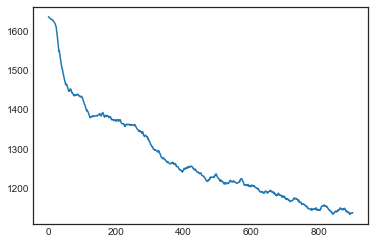

hor bssek
Ble coul havg anrhy thlr tolenth, fone? tho wg ranld at wiiln, ain lerin ho keUV mot efheaJofertherd bomr  heet ior Mheorankre bla ghad agaglt toKthithe, fi youl eon thit hoDfhe Wyars soukdt


In [16]:
layers = [RNNLayer(hidden_size=256, output_size=62)]
mod = RNNModel(layers=layers,
               vocab_size=62, sequence_length=10,
               loss=SoftmaxCrossEntropy())
optim = SGD(lr=0.001, gradient_clipping=True)
trainer = RNNTrainer('input.txt', mod, optim)
trainer.train(1000, sample_every=100)

RNNNode를 사용하니 지역 최댓값에서 빠져나오지 못했다. `LSTM`으로 대체해보자. 

# LSTM

## `LSTMNode`

In [17]:
class LSTMNode:

    def __init__(self):
        '''
        param hidden_size: int - 본 노드가 속한 LSTM_Layer의 은닉 뉴런 수.
        param vocab_size: int - 사용되는 글자의 가짓수.
        '''
        pass
        
    def forward(self, 
                X_in: ndarray, 
                H_in: ndarray, 
                C_in: ndarray, 
                params_dict: Dict[str, Dict[str, ndarray]]):
        '''
        param X_in: 모양이 (batch_size, vocab_size)인 넘파이 배열
        param H_in: 모양이 (batch_size, hidden_size)인 넘파이 배열
        param C_in: 모양이 (batch_size, hidden_size)인 넘파이 배열
        return self.X_out: 모양이 (batch_size, output_size)인 넘파이 배열
        return self.H: 모양이 (batch_size, hidden_size)인 넘파이 배열
        return self.C: 모양이 (batch_size, hidden_size)인 넘파이 배열
        '''
        self.X_in = X_in
        self.C_in = C_in

        self.Z = np.column_stack((X_in, H_in))
        
        self.f_int = np.dot(self.Z, params_dict['W_f']['value']) + params_dict['B_f']['value']
        self.f = sigmoid(self.f_int)
        
        self.i_int = np.dot(self.Z, params_dict['W_i']['value']) + params_dict['B_i']['value']
        self.i = sigmoid(self.i_int)
        self.C_bar_int = np.dot(self.Z, params_dict['W_c']['value']) + params_dict['B_c']['value']
        self.C_bar = tanh(self.C_bar_int)

        self.C_out = self.f * C_in + self.i * self.C_bar
        self.o_int = np.dot(self.Z, params_dict['W_o']['value']) + params_dict['B_o']['value']
        self.o = sigmoid(self.o_int)
        self.H_out = self.o * tanh(self.C_out)

        self.X_out = np.dot(self.H_out, params_dict['W_v']['value']) + params_dict['B_v']['value']
        
        return self.X_out, self.H_out, self.C_out 


    def backward(self, 
                 X_out_grad: ndarray, 
                 H_out_grad: ndarray, 
                 C_out_grad: ndarray, 
                 params_dict: Dict[str, Dict[str, ndarray]]):
        '''
        param loss_grad:모양이  (1, vocab_size)인 넘파이 배열
        param dh_next: 모양이  (1, hidden_size)인 넘파이 배열
        param dC_next: 모양이  (1, hidden_size)인 넘파이 배열
        param LSTM_Params: LSTM_Params 객체
        return self.dx_prev: 모양이  (1, vocab_size)인 넘파이 배열
        return self.dH_prev: 모양이  (1, hidden_size)인 넘파이 배열
        return self.dC_prev: 모양이  (1, hidden_size)인 넘파이 배열
        '''
        
        assert_same_shape(X_out_grad, self.X_out)
        assert_same_shape(H_out_grad, self.H_out)
        assert_same_shape(C_out_grad, self.C_out)

        params_dict['W_v']['deriv'] += np.dot(self.H_out.T, X_out_grad)
        params_dict['B_v']['deriv'] += X_out_grad.sum(axis=0)

        dh_out = np.dot(X_out_grad, params_dict['W_v']['value'].T)        
        dh_out += H_out_grad
                         
        do = dh_out * tanh(self.C_out)
        do_int = dsigmoid(self.o_int) * do
        params_dict['W_o']['deriv'] += np.dot(self.Z.T, do_int)
        params_dict['B_o']['deriv'] += do_int.sum(axis=0)

        dC_out = dh_out * self.o * dtanh(self.C_out)
        dC_out += C_out_grad
        dC_bar = dC_out * self.i
        dC_bar_int = dtanh(self.C_bar_int) * dC_bar
        params_dict['W_c']['deriv'] += np.dot(self.Z.T, dC_bar_int)
        params_dict['B_c']['deriv'] += dC_bar_int.sum(axis=0)

        di = dC_out * self.C_bar
        di_int = dsigmoid(self.i_int) * di
        params_dict['W_i']['deriv'] += np.dot(self.Z.T, di_int)
        params_dict['B_i']['deriv'] += di_int.sum(axis=0)

        df = dC_out * self.C_in
        df_int = dsigmoid(self.f_int) * df
        params_dict['W_f']['deriv'] += np.dot(self.Z.T, df_int)
        params_dict['B_f']['deriv'] += df_int.sum(axis=0)

        dz = (np.dot(df_int, params_dict['W_f']['value'].T)
             + np.dot(di_int, params_dict['W_i']['value'].T)
             + np.dot(dC_bar_int, params_dict['W_c']['value'].T)
             + np.dot(do_int, params_dict['W_o']['value'].T))
    
        dx_prev = dz[:, :self.X_in.shape[1]]
        dH_prev = dz[:, self.X_in.shape[1]:]
        dC_prev = self.f * dC_out

        return dx_prev, dH_prev, dC_prev

## `LSTMLayer`

In [19]:
class LSTMLayer:

    def __init__(self,
                 hidden_size: int,
                 output_size: int,
                 weight_scale: float = 0.01):
        '''
        param sequence_length: int - 입력받을 연속열의 길이
        param vocab_size: int - 사용되는 글자의 가짓수
        param hidden_size: int - 본 노드가 속한 LSTM_Layer의 은닉 뉴런 수
        param learning_rate: float - 학습률
        '''
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.weight_scale = weight_scale
        self.start_H = np.zeros((1, hidden_size))
        self.start_C = np.zeros((1, hidden_size))        
        self.first = True

        
    def _init_params(self,
                     input_: ndarray):
        
        self.vocab_size = input_.shape[2]

        self.params = {}
        self.params['W_f'] = {}
        self.params['B_f'] = {}
        self.params['W_i'] = {}
        self.params['B_i'] = {}
        self.params['W_c'] = {}
        self.params['B_c'] = {}
        self.params['W_o'] = {}
        self.params['B_o'] = {}        
        self.params['W_v'] = {}
        self.params['B_v'] = {}
        
        self.params['W_f']['value'] = np.random.normal(loc=0.0,
                                                       scale=self.weight_scale,
                                                       size =(self.hidden_size + self.vocab_size, self.hidden_size))
        self.params['B_f']['value'] = np.random.normal(loc=0.0,
                                                       scale=self.weight_scale,
                                                       size=(1, self.hidden_size))
        self.params['W_i']['value'] = np.random.normal(loc=0.0,
                                                       scale=self.weight_scale,
                                                       size=(self.hidden_size + self.vocab_size, self.hidden_size))
        self.params['B_i']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.hidden_size))
        self.params['W_c']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(self.hidden_size + self.vocab_size, self.hidden_size))
        self.params['B_c']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.hidden_size))
        self.params['W_o']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(self.hidden_size + self.vocab_size, self.hidden_size))
        self.params['B_o']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.hidden_size))       
        self.params['W_v']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(self.hidden_size, self.output_size))
        self.params['B_v']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.output_size))
        
        for key in self.params.keys():
            self.params[key]['deriv'] = np.zeros_like(self.params[key]['value'])
        
        self.cells = [LSTMNode() for x in range(input_.shape[1])]


    def _clear_gradients(self):
        for key in self.params.keys():
            self.params[key]['deriv'] = np.zeros_like(self.params[key]['deriv'])
                    
        
    def forward(self, x_seq_in: ndarray):
        '''
        param x_seq_in: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
        return x_seq_out: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
        '''
        if self.first:
            self._init_params(x_seq_in)
            self.first=False
        
        batch_size = x_seq_in.shape[0]
        
        H_in = np.copy(self.start_H)
        C_in = np.copy(self.start_C)
        
        H_in = np.repeat(H_in, batch_size, axis=0)
        C_in = np.repeat(C_in, batch_size, axis=0)        

        sequence_length = x_seq_in.shape[1]
        
        x_seq_out = np.zeros((batch_size, sequence_length, self.output_size))
        
        for t in range(sequence_length):

            x_in = x_seq_in[:, t, :]
            
            y_out, H_in, C_in = self.cells[t].forward(x_in, H_in, C_in, self.params)
      
            x_seq_out[:, t, :] = y_out
    
        self.start_H = H_in.mean(axis=0, keepdims=True)
        self.start_C = C_in.mean(axis=0, keepdims=True)        
        
        return x_seq_out


    def backward(self, x_seq_out_grad: ndarray):
        '''
        param loss_grad: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
        return loss_grad_out: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
        '''
        
        batch_size = x_seq_out_grad.shape[0]
        
        h_in_grad = np.zeros((batch_size, self.hidden_size))
        c_in_grad = np.zeros((batch_size, self.hidden_size))        
        
        num_chars = x_seq_out_grad.shape[1]
        
        x_seq_in_grad = np.zeros((batch_size, num_chars, self.vocab_size))
        
        for t in reversed(range(num_chars)):
            
            x_out_grad = x_seq_out_grad[:, t, :]

            grad_out, h_in_grad, c_in_grad = \
                self.cells[t].backward(x_out_grad, h_in_grad, c_in_grad, self.params)
        
            x_seq_in_grad[:, t, :] = grad_out
        
        return x_seq_in_grad

## `LSTMModel`

In [20]:
class LSTMModel(object):
    '''
    입력과 목푯값을 입력받아 신경망을 학습하고 손실을 계산한다
    '''
    def __init__(self, 
                 layers: List[LSTMLayer],
                 sequence_length: int, 
                 vocab_size: int, 
                 hidden_size: int,
                 loss: Loss):
        '''
        param num_layers: int - 신경망의 층 수
        param sequence_length: int - 입력받을 연속열의 길이
        param vocab_size: int - 사용되는 글자의 가짓수
        param hidden_size: int - 각 층의 은닉 뉴런 수
        '''
        self.layers = layers
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        self.loss = loss
        for layer in self.layers:
            setattr(layer, 'sequence_length', sequence_length)

        
    def forward(self, 
                x_batch: ndarray):
        '''
        param inputs: list of integers - 길이가 sequence_length인 리스트, 입력되는 연속열의 각 글자에 해당하는 정수의 리스트다.
        returns x_batch_in: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
        '''       
        
        for layer in self.layers:

            x_batch = layer.forward(x_batch)
                
        return x_batch
        
    def backward(self, 
                 loss_grad: ndarray):
        '''
        param loss_grad: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
        returns loss: float, 평균제곱오차
        '''

        for layer in reversed(self.layers):

            loss_grad = layer.backward(loss_grad)
            
        return loss_grad
                
    def single_step(self, 
                    x_batch: ndarray, 
                    y_batch: ndarray):
        '''
        여기서 수행되는 과정:
        1. 순방향 계산, 소프트맥스 함수 통과
        2. 손실 및 손실의 기울기 계산
        3. 역방향 계산
        4. 파라미터 수정
        param inputs: 길이가 sequence_length인 리스트, 입력되는 연속열의 각 글자에 해당하는 정수의 리스트다.
        param targets: 길이가 sequence_length인 리스트, 목푯값인 글자에 해당하는 정수의 리스트다.
        return loss
        '''  
        
        x_batch_out = self.forward(x_batch)
        
        loss = self.loss.forward(x_batch_out, y_batch)
        
        loss_grad = self.loss.backward()
        
        for layer in self.layers:
            layer._clear_gradients()
        
        self.backward(loss_grad)
        return loss

# GRUs

## `GRUNode`

In [21]:
class GRUNode(object):

    def __init__(self):
        '''
        param hidden_size: int - 본 노드가 속한 LSTM_Layer의 은닉 뉴런 수.
        param vocab_size: int - 사용되는 글자의 가짓수.
        '''
        pass
        
    def forward(self, 
                X_in: ndarray, 
                H_in: ndarray,
                params_dict: Dict[str, Dict[str, ndarray]]) -> Tuple[ndarray]:
        '''
        param X_in: 모양이 (batch_size, vocab_size)인 넘파이 배열
        param H_in: 모양이 (batch_size, hidden_size)인 넘파이 배열
        return self.X_out: 모양이 (batch_size, vocab_size)인 넘파이 배열
        return self.H_out: 모양이 (batch_size, hidden_size)인 넘파이 배열
        '''
        self.X_in = X_in
        self.H_in = H_in        
        
        # 리셋 게이트
        self.X_r = np.dot(X_in, params_dict['W_xr']['value'])
        self.H_r = np.dot(H_in, params_dict['W_hr']['value'])

        # 수정 게이트       
        self.X_u = np.dot(X_in, params_dict['W_xu']['value'])
        self.H_u = np.dot(H_in, params_dict['W_hu']['value'])        
        
        # 게이트 
        self.r_int = self.X_r + self.H_r + params_dict['B_r']['value']
        self.r = sigmoid(self.r_int)
        
        self.u_int = self.X_r + self.H_r + params_dict['B_u']['value']
        self.u = sigmoid(self.u_int)

        # 새로운 상태        
        self.h_reset = self.r * H_in
        self.X_h = np.dot(X_in, params_dict['W_xh']['value'])
        self.H_h = np.dot(self.h_reset, params_dict['W_hh']['value']) 
        self.h_bar_int = self.X_h + self.H_h + params_dict['B_h']['value']
        self.h_bar = tanh(self.h_bar_int)        
        
        self.H_out = self.u * self.H_in + (1 - self.u) * self.h_bar

        self.X_out = np.dot(self.H_out, params_dict['W_v']['value']) + params_dict['B_v']['value']
        
        return self.X_out, self.H_out


    def backward(self, 
                 X_out_grad: ndarray, 
                 H_out_grad: ndarray, 
                 params_dict: Dict[str, Dict[str, ndarray]]):
        
        params_dict['B_v']['deriv'] += X_out_grad.sum(axis=0)
        params_dict['W_v']['deriv'] += np.dot(self.H_out.T, X_out_grad)

        dh_out = np.dot(X_out_grad, params_dict['W_v']['value'].T)        
        dh_out += H_out_grad
                         
        du = self.H_in * H_out_grad - self.h_bar * H_out_grad 
        dh_bar = (1 - self.u) * H_out_grad
        
        dh_bar_int = dh_bar * dtanh(self.h_bar_int)
        params_dict['B_h']['deriv'] += dh_bar_int.sum(axis=0)
        params_dict['W_xh']['deriv'] += np.dot(self.X_in.T, dh_bar_int)
        
        dX_in = np.dot(dh_bar_int, params_dict['W_xh']['value'].T)
 
        params_dict['W_hh']['deriv'] += np.dot(self.h_reset.T, dh_bar_int)
        dh_reset = np.dot(dh_bar_int, params_dict['W_hh']['value'].T)   
        
        dr = dh_reset * self.H_in
        dH_in = dh_reset * self.r        
        
        # update branch
        du_int = dsigmoid(self.u_int) * du
        params_dict['B_u']['deriv'] += du_int.sum(axis=0)

        dX_in += np.dot(du_int, params_dict['W_xu']['value'].T)
        params_dict['W_xu']['deriv'] += np.dot(self.X_in.T, du_int)
        
        dH_in += np.dot(du_int, params_dict['W_hu']['value'].T)
        params_dict['W_hu']['deriv'] += np.dot(self.H_in.T, du_int)        

        # reset branch
        dr_int = dsigmoid(self.r_int) * dr
        params_dict['B_r']['deriv'] += dr_int.sum(axis=0)

        dX_in += np.dot(dr_int, params_dict['W_xr']['value'].T)
        params_dict['W_xr']['deriv'] += np.dot(self.X_in.T, dr_int)
        
        dH_in += np.dot(dr_int, params_dict['W_hr']['value'].T)
        params_dict['W_hr']['deriv'] += np.dot(self.H_in.T, dr_int)   
        
        return dX_in, dH_in

## `GRULayer`

In [22]:
class GRULayer(object):

    def __init__(self,
                 hidden_size: int,
                 output_size: int,
                 weight_scale: float = 0.01):
        '''
        param sequence_length: int - 연속열의 길이
        param vocab_size: int - 사용되는 글자의 가짓수
        param hidden_size: int - 본 노드가 속한 LSTM_Layer의 은닉 뉴런 수.
        param learning_rate: float - 학습률
        '''
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.weight_scale = weight_scale
        self.start_H = np.zeros((1, hidden_size))       
        self.first = True

        
    def _init_params(self,
                     input_: ndarray):
        
        self.vocab_size = input_.shape[2]

        self.params = {}
        self.params['W_xr'] = {}
        self.params['W_hr'] = {}
        self.params['B_r'] = {}
        self.params['W_xu'] = {}
        self.params['W_hu'] = {}
        self.params['B_u'] = {}
        self.params['W_xh'] = {}
        self.params['W_hh'] = {}
        self.params['B_h'] = {}        
        self.params['W_v'] = {}
        self.params['B_v'] = {}
        
        self.params['W_xr']['value'] = np.random.normal(loc=0.0,
                                                        scale=self.weight_scale,
                                                        size=(self.vocab_size, self.hidden_size))
        self.params['W_hr']['value'] = np.random.normal(loc=0.0,
                                                        scale=self.weight_scale,
                                                        size=(self.hidden_size, self.hidden_size))        
        self.params['B_r']['value'] = np.random.normal(loc=0.0,
                                                       scale=self.weight_scale,
                                                       size=(1, self.hidden_size))
        self.params['W_xu']['value'] = np.random.normal(loc=0.0,
                                                        scale=self.weight_scale,
                                                        size=(self.vocab_size, self.hidden_size))
        self.params['W_hu']['value'] = np.random.normal(loc=0.0,
                                                       scale=self.weight_scale,
                                                       size=(self.hidden_size, self.hidden_size))
        self.params['B_u']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.hidden_size))
        self.params['W_xh']['value'] = np.random.normal(loc=0.0,
                                                       scale=self.weight_scale,
                                                       size=(self.vocab_size, self.hidden_size))
        self.params['W_hh']['value'] = np.random.normal(loc=0.0,
                                                       scale=self.weight_scale,
                                                       size=(self.hidden_size, self.hidden_size))
        self.params['B_h']['value'] = np.random.normal(loc=0.0,
                                                       scale=1.0,
                                                       size=(1, self.hidden_size))
        self.params['W_v']['value'] = np.random.normal(loc=0.0,
                                                       scale=1.0,
                                                       size=(self.hidden_size, self.output_size))
        self.params['B_v']['value'] = np.random.normal(loc=0.0,
                                                       scale=1.0,
                                                       size=(1, self.output_size))    
        
        for key in self.params.keys():
            self.params[key]['deriv'] = np.zeros_like(self.params[key]['value'])
        
        self.cells = [GRUNode() for x in range(input_.shape[1])]


    def _clear_gradients(self):
        for key in self.params.keys():
            self.params[key]['deriv'] = np.zeros_like(self.params[key]['deriv'])
                    
        
    def forward(self, x_seq_in: ndarray):
        '''
        param x_seq_in: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
        return x_seq_out: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
        '''
        if self.first:
            self._init_params(x_seq_in)
            self.first=False
        
        batch_size = x_seq_in.shape[0]
        
        H_in = np.copy(self.start_H)

        H_in = np.repeat(H_in, batch_size, axis=0)      

        sequence_length = x_seq_in.shape[1]
        
        x_seq_out = np.zeros((batch_size, sequence_length, self.output_size))
        
        for t in range(sequence_length):

            x_in = x_seq_in[:, t, :]
            
            y_out, H_in = self.cells[t].forward(x_in, H_in, self.params)
      
            x_seq_out[:, t, :] = y_out
    
        self.start_H = H_in.mean(axis=0, keepdims=True)     
        
        return x_seq_out


    def backward(self, x_seq_out_grad: ndarray):
        '''
        param loss_grad: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
        return loss_grad_out: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
        '''
        
        batch_size = x_seq_out_grad.shape[0]
        
        h_in_grad = np.zeros((batch_size, self.hidden_size))        
        
        num_chars = x_seq_out_grad.shape[1]
        
        x_seq_in_grad = np.zeros((batch_size, num_chars, self.vocab_size))
        
        for t in reversed(range(num_chars)):
            
            x_out_grad = x_seq_out_grad[:, t, :]

            grad_out, h_in_grad = \
                self.cells[t].backward(x_out_grad, h_in_grad, self.params)
        
            x_seq_in_grad[:, t, :] = grad_out
        
        return x_seq_in_grad

# Experiments

### Single LSTM layer

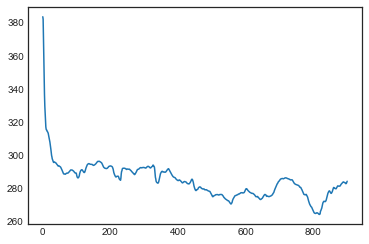

nno
wcnc c::cUNIo
qSfN, uYwaisacFaee,TbHy:KTToTyacoiciNIr
tocv

b
HN
:TTnsaid khnna  o

RT HeI:w
Ne ln, any.snwwA:nNANRHa
ah kot n, nc, SaS

CKT:I nr'ive ehc.tS sy Rwpoc:
S Nsi:nchnen
hey lO
BWLy :anN


In [25]:
layers1 = [LSTMLayer(hidden_size=256, output_size=62, weight_scale=0.01)]
mod = RNNModel(layers=layers1,
               vocab_size=62, sequence_length=25,
               loss=SoftmaxCrossEntropy())
optim = AdaGrad(lr=0.01, gradient_clipping=True)
trainer = RNNTrainer('input.txt', mod, optim, batch_size=3)
trainer.train(1000, sample_every=100)

## Three variants of multiple layers:

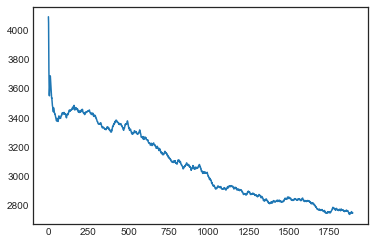

esss
On pan bk thed .orlsrwus lo r, sot yhard, at by hatt tat anrhlsy lee derld ronnJ nom thas ut lithy
be vaubasF:

d-rey oenes sira. Naave.
.e blng a ase ued
oudll
aI,
hh sannus and soid mrtsum In t


In [26]:
layers2 = [RNNLayer(hidden_size=256, output_size=128, weight_scale=0.1),
           LSTMLayer(hidden_size=256, output_size=62, weight_scale=0.01)]
mod = RNNModel(layers=layers2,
               vocab_size=62, sequence_length=25,
               loss=SoftmaxCrossEntropy())
optim = AdaGrad(lr=0.01, gradient_clipping=True)
trainer = RNNTrainer('input.txt', mod, optim, batch_size=32)
trainer.train(2000, sample_every=100)

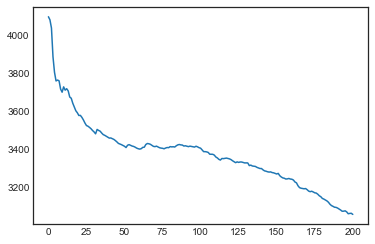


Eiccoucs betr, ou Ayas, auinl. Was, nle fe Mnye assy'se.

ora dej: Tinb at tod fis ?, gage-
Oer as
Iseise al mauggMm ht te  asy hoB. hom auft wlle ye she ou tor ssar sus KI
LoTher mtn, on tats'ie me



KeyboardInterrupt: 

In [27]:
layers2 = [LSTMLayer(hidden_size=256, output_size=128, weight_scale=0.1),
           LSTMLayer(hidden_size=256, output_size=62, weight_scale=0.01)]
mod = RNNModel(layers=layers2,
               vocab_size=62, sequence_length=25,
               loss=SoftmaxCrossEntropy())
optim = SGD(lr=0.01, gradient_clipping=True)
trainer = RNNTrainer('input.txt', mod, optim, batch_size=32)
trainer.train(2000, sample_every=100)

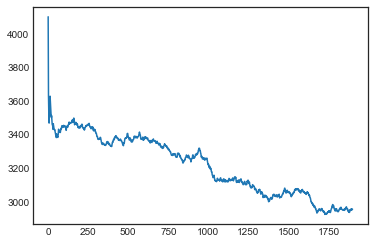

 bgr,
th crt woerie, mlus no badese t wivete rune soemly,
T
O, t:
woedaw,
orrf,e br yO euatge se wanm dinye . tinn wTeiles ne toe nd wigt
inP
cth ihe fos bish se wer arsethy serfsibrmt pre !omey we re


In [ ]:
layers3 = [GRULayer(hidden_size=256, output_size=128, weight_scale=0.1),
           LSTMLayer(hidden_size=256, output_size=62, weight_scale=0.01)]
mod = RNNModel(layers=layers3,
               vocab_size=62, sequence_length=25,
               loss=SoftmaxCrossEntropy())
optim = AdaGrad(lr=0.01, gradient_clipping=True)
trainer = RNNTrainer('input.txt', mod, optim, batch_size=32)
trainer.train(2000, sample_every=100)